In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
#data = pd.read_csv('data/red_normal.csv')
data = pd.read_csv('data/white_normal.csv')
#data = pd.read_csv('data/wine_normal.csv')
#data = pd.read_csv('data/wine_data.csv', usecols=range(14)[1:])

In [3]:
pca_flag = False

In [4]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,quality
0,0.212659,0.044742,0.213258,2.821061,0.116275,0.685891,0.744489,2.331274,-1.246794,-0.349149,-1.393010,6
1,-0.645329,0.362247,0.047996,-0.944669,0.372436,-1.472748,-0.149669,-0.009153,0.739953,0.001342,-0.824192,6
2,1.454524,0.153504,0.543783,0.100272,0.433714,-0.084188,-0.973236,0.358628,0.475053,-0.436771,-0.336633,6
3,0.447597,-0.423808,-0.117266,0.415726,0.889530,0.769373,1.120977,0.525802,0.011479,-0.787262,-0.499152,6
4,0.447597,-0.423808,-0.117266,0.415726,0.889530,0.769373,1.120977,0.525802,0.011479,-0.787262,-0.499152,6


In [5]:
data.shape

(4898, 12)

In [6]:
if 'type' in data.columns:
    data = pd.get_dummies(data, columns = ['type'])
    data.drop('type_white', axis=1, inplace=True)
temp = data['quality']
data.drop('quality', axis=1, inplace=True)
data['quality'] = temp

In [7]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,quality
0,0.212659,0.044742,0.213258,2.821061,0.116275,0.685891,0.744489,2.331274,-1.246794,-0.349149,-1.393010,6
1,-0.645329,0.362247,0.047996,-0.944669,0.372436,-1.472748,-0.149669,-0.009153,0.739953,0.001342,-0.824192,6
2,1.454524,0.153504,0.543783,0.100272,0.433714,-0.084188,-0.973236,0.358628,0.475053,-0.436771,-0.336633,6
3,0.447597,-0.423808,-0.117266,0.415726,0.889530,0.769373,1.120977,0.525802,0.011479,-0.787262,-0.499152,6
4,0.447597,-0.423808,-0.117266,0.415726,0.889530,0.769373,1.120977,0.525802,0.011479,-0.787262,-0.499152,6


Our approach is to think about the train as points sitting in $\mathbb R^{12}$ and we conjecture that they have some structure in the form of lower dimensional shape. To have a more concrete visualization, think about $\mathbb R^3$ an our train might have the shape of a sphere, a torus, a bent sheet of paper etc.

Obviously, the train is going to be pretty irregular and we don't expect it to form a really nice submanifold. Nonetheless, we draw from the notion of a triangulization from geometry. Roughly, it says that we can approximate any shape by only using linear pieces without changing the geometric properties too much.

To translate this into our setting, we are going to divide the ranges of the features into a grid and for each small piece we are going to find a linear model to predict the quality. Given a new example, we only need to find where it lies on the grid and make a prediction using the closest model.

In [8]:
if pca_flag:
    from sklearn.decomposition import PCA
    # To perform PCA we keep categorical variables in another place
    name_type = [name for name in data.columns if 'type' in name]
    numerical = [name for name in data.columns if 'type' not in name and name != 'quality']
    if len(name_type):
        temp_type = data[name_type]
    temp_quality = data[['quality']]
    data = data[numerical]
    print("data.head()")
    print(data.head(),"\n")
    
    pca = PCA(svd_solver='full')
    pca.fit(data)
    print("explained variance ratio")
    print(pca.explained_variance_ratio_,"\n")
    data = pd.DataFrame(pca.transform(data))
    print("data.head()")
    print(data.head())
    
    if len(name_type):
        data['type_red'] = temp_type
    data['quality'] = temp_quality
    data.rename(columns={0:'alcohol', 1:'density', 2:'volatile_acidity'}, inplace=True)

In [9]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,quality
0,0.212659,0.044742,0.213258,2.821061,0.116275,0.685891,0.744489,2.331274,-1.246794,-0.349149,-1.393010,6
1,-0.645329,0.362247,0.047996,-0.944669,0.372436,-1.472748,-0.149669,-0.009153,0.739953,0.001342,-0.824192,6
2,1.454524,0.153504,0.543783,0.100272,0.433714,-0.084188,-0.973236,0.358628,0.475053,-0.436771,-0.336633,6
3,0.447597,-0.423808,-0.117266,0.415726,0.889530,0.769373,1.120977,0.525802,0.011479,-0.787262,-0.499152,6
4,0.447597,-0.423808,-0.117266,0.415726,0.889530,0.769373,1.120977,0.525802,0.011479,-0.787262,-0.499152,6


In [10]:
train = data.sample(frac=0.8).sort_index()

In [11]:
train_index = train.index

In [12]:
train_index.shape

(3918,)

In [13]:
test = data.iloc[~data.index.isin(train_index)]

In [14]:
test.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,quality
17,-0.772730,2.935388,1.204832,-1.023532,-1.143387,-0.147790,-1.490907,-1.614018,0.938628,-0.874884,1.857382,8
18,0.678301,0.748649,0.709045,-1.043248,-0.784616,-1.128486,0.768020,-0.778151,-0.452095,0.351832,0.638485,6
35,0.563469,0.153504,0.791676,-0.924953,1.907388,-0.745751,-0.361444,-1.179367,0.011479,-0.612016,1.857382,5
38,0.563469,-0.301232,0.461152,2.278875,0.835623,0.685891,0.250349,1.963493,0.143929,-1.137752,-1.555530,5
44,-0.148033,-0.423808,-0.613053,-0.984101,0.994970,0.095329,0.368001,-0.209761,0.342604,0.614700,-0.824192,6


In [15]:
train.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,quality
0,0.212659,0.044742,0.213258,2.821061,0.116275,0.685891,0.744489,2.331274,-1.246794,-0.349149,-1.393010,6
1,-0.645329,0.362247,0.047996,-0.944669,0.372436,-1.472748,-0.149669,-0.009153,0.739953,0.001342,-0.824192,6
2,1.454524,0.153504,0.543783,0.100272,0.433714,-0.084188,-0.973236,0.358628,0.475053,-0.436771,-0.336633,6
3,0.447597,-0.423808,-0.117266,0.415726,0.889530,0.769373,1.120977,0.525802,0.011479,-0.787262,-0.499152,6
4,0.447597,-0.423808,-0.117266,0.415726,0.889530,0.769373,1.120977,0.525802,0.011479,-0.787262,-0.499152,6


In [16]:
train.describe()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,quality
count,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000
mean,-0.010819,0.007873,-0.000933,-0.002952,-0.001615,-0.005026,-0.006493,-0.007109,0.002926,0.008811,0.009221,5.875447
std,0.993133,1.004154,1.004564,1.004695,1.014353,1.005234,1.003538,1.005359,0.997362,1.009081,1.003027,0.875330
min,-4.286549,-2.977334,-2.761461,-1.141827,-3.821940,-4.249867,-3.043919,-2.312802,-3.101091,-2.364468,-2.043089,3.000000
25%,-0.645329,-0.681290,-0.530422,-0.924953,-0.537296,-0.578715,-0.714401,-0.778151,-0.650770,-0.699639,-0.824192,5.000000
50%,-0.026670,-0.067173,-0.117266,-0.239827,-0.019013,0.151763,-0.102608,-0.086053,-0.054746,-0.086281,-0.092853,6.000000
75%,0.563469,0.608241,0.440494,0.672032,0.433714,0.728067,0.673898,0.692975,0.607503,0.527077,0.719745,6.000000
max,6.753140,4.736912,10.955302,11.712916,6.380886,4.338200,7.097720,15.029763,4.183648,5.171074,2.995020,9.000000


In [17]:
# Dictionary representing the gird. Each row represents a feature and the columns the partitions.
# The shape of this matrix is a hyperparameter of our model.
# The distance notion that we use is also a hyperparameter.
grid = {}
for name in ['alcohol', 'density', 'volatile_acidity']: #train.columns:
    if not "type" in name:
        grid[name] = []

In [18]:
grid

{'alcohol': [], 'density': [], 'volatile_acidity': []}

In [19]:
# We start small, for each feature we just give one separation point.
for element in grid:
    grid[element] = np.median(train[element])

In [20]:
grid

{'alcohol': -0.092853191932975435,
 'density': -0.086052989055631218,
 'volatile_acidity': -0.067172866990757224}

This generates a split of the train into $2^{12}$ pieces. That is 4096 different pieces so we don't have enough train to support this partition. We need to select a subset of the feautes.

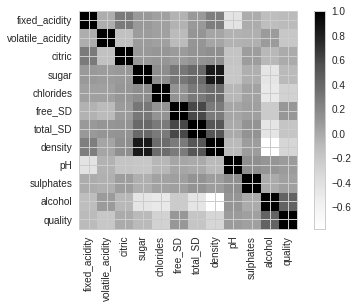

In [21]:
tick_marks = [i for i in range(len(train.columns))]
plt.imshow(train.corr(), interpolation='nearest')
plt.colorbar()
plt.xticks(tick_marks, train.columns, rotation='vertical')
plt.yticks(tick_marks, train.columns)
plt.show()

In [22]:
correlations = pd.DataFrame(train.corr()['quality']).apply(np.abs)
correlations.sort_values(by='quality', ascending=False)

,quality
quality,1.000000
alcohol,0.433068
density,0.303462
chlorides,0.275536
volatile_acidity,0.187553
total_SD,0.177047
free_SD,0.101279
fixed_acidity,0.096771
sugar,0.090816
pH,0.081453


It seems reasonable to split along alcohol, density and volatile_acidity. This way we will have 8 different partitions

In [23]:
dfs = []

In [24]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density > grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [25]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density > grid["density"] ) 
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [26]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [27]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [28]:
dfs.append(train[(train.alcohol < grid["alcohol"])
                 & (train.density > grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [29]:
dfs.append(train[(train.alcohol < grid["alcohol"]) 
                 & (train.density > grid["density"])
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [30]:
dfs.append(train[(train.alcohol < grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [31]:
dfs.append(train[(train.alcohol < grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [32]:
for df in dfs:
    print(df.shape)

(151, 12)
(162, 12)
(781, 12)
(694, 12)
(769, 12)
(696, 12)
(160, 12)
(197, 12)


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score

In [34]:
def trainLG(df):
    X, y = df.ix[:,:-1], df['quality']
    clf = LogisticRegression(penalty='l2', 
                             C=10,
                             n_jobs=-1)
    clf.fit(X, y)
    return clf

In [35]:
clfs = []
for df in dfs:
    clfs.append(trainLG(df))

In [36]:
X_test, y_test = test.ix[:,:-1], test['quality']

In [37]:
X_test.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol
17,-0.772730,2.935388,1.204832,-1.023532,-1.143387,-0.147790,-1.490907,-1.614018,0.938628,-0.874884,1.857382
18,0.678301,0.748649,0.709045,-1.043248,-0.784616,-1.128486,0.768020,-0.778151,-0.452095,0.351832,0.638485
35,0.563469,0.153504,0.791676,-0.924953,1.907388,-0.745751,-0.361444,-1.179367,0.011479,-0.612016,1.857382
38,0.563469,-0.301232,0.461152,2.278875,0.835623,0.685891,0.250349,1.963493,0.143929,-1.137752,-1.555530
44,-0.148033,-0.423808,-0.613053,-0.984101,0.994970,0.095329,0.368001,-0.209761,0.342604,0.614700,-0.824192


In [38]:
def getPiece(row): 
    if row.alcohol > grid["alcohol"]:
        if row.density > grid["density"]:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 0
            else:
                return 1
        else:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 2
            else:
                return 3
    else:
        if row.density > grid["density"]:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 4
            else:
                return 5
        else:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 6
            else:
                return 7
        

def generatePrediction(df):
    y_pred = []
    for idx in df.index:
        temp = getPiece(df.loc[idx])
        jdx = clfs[temp].predict(df.loc[idx].reshape(1,-1))
        y_pred.append(jdx)
    return pd.DataFrame(y_pred)

In [39]:
y_pred = generatePrediction(X_test)

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


# MAE

In [40]:
mean_absolute_error(y_test, y_pred)

0.54591836734693877

# ACCURACY

In [41]:
accuracy_score(y_test, y_pred)

0.5295918367346939

## Using Ensemble of all the grid pieces

In [42]:
y_wild = pd.DataFrame([])
for clf in clfs:
    temp = clf.predict(X_test)
    y_wild = pd.concat([y_wild, pd.DataFrame(temp)], axis=1)

In [43]:
y_mode = y_wild.mode(axis=1)[0].apply(np.rint)

In [44]:
print(mean_absolute_error(y_test, y_mode))
print(accuracy_score(y_test, y_mode))

0.59387755102
0.483673469388


In [45]:
y_mean = y_wild.mean(axis=1).apply(np.rint)

In [46]:
print(mean_absolute_error(y_test, y_mean))
print(accuracy_score(y_test, y_mean))

0.578571428571
0.497959183673


In [47]:
from scipy import stats

In [48]:
y_geom = y_wild.apply(stats.gmean,axis=1).apply(np.rint)

In [49]:
print(mean_absolute_error(y_test, y_geom))
print(accuracy_score(y_test, y_geom))

0.592857142857
0.489795918367


In [50]:
y_comp = pd.concat([y_wild, y_test.reset_index(drop=True)], axis = 1, ignore_index=True)

In [51]:
y_comp

,0,1,2,3,4,5,6,7,8
0,8,5,7,3,6,6,7,4,8
1,5,7,6,5,5,6,6,6,6
2,6,4,6,6,6,6,4,6,5
3,6,6,6,3,5,5,5,7,5
4,5,6,6,6,5,5,5,6,6
5,6,7,6,6,6,6,6,6,6
6,6,7,6,6,6,6,6,6,7
7,6,6,6,6,5,6,5,7,6
8,8,7,7,6,6,6,7,6,7
9,5,6,5,5,5,5,5,6,5


In [52]:
import xgboost

OSError: /home/martin/anaconda3/bin/../lib/libgomp.so.1: version `GOMP_4.0' not found (required by /home/martin/xgboost/python-package/xgboost/../../lib/libxgboost.so)